# Final Figures for PIK3CA Story
### Proteomic abundance

##### These notebooks are used to create the figures used for our PIK3CA story. For more detailed analysis of what is being done, see Notebook 2 in this folder.

### Standard Imports

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import json
import operator

#import the Endometrial data from CPTAC package
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. This import contains
information about the package. In order to access a specific data set,
import a CPTAC subfolder by either 'import CPTAC.DataName' or 'from
CPTAC import DataName'.
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


### Get proteomics data and somatic mutations from CPTAC

In [2]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()

### Make Proteomics box plot for AKT1, AKT2, PTEN, PIK3CA
##### Show data for hotspot mutations vs wildtype in cancer patients

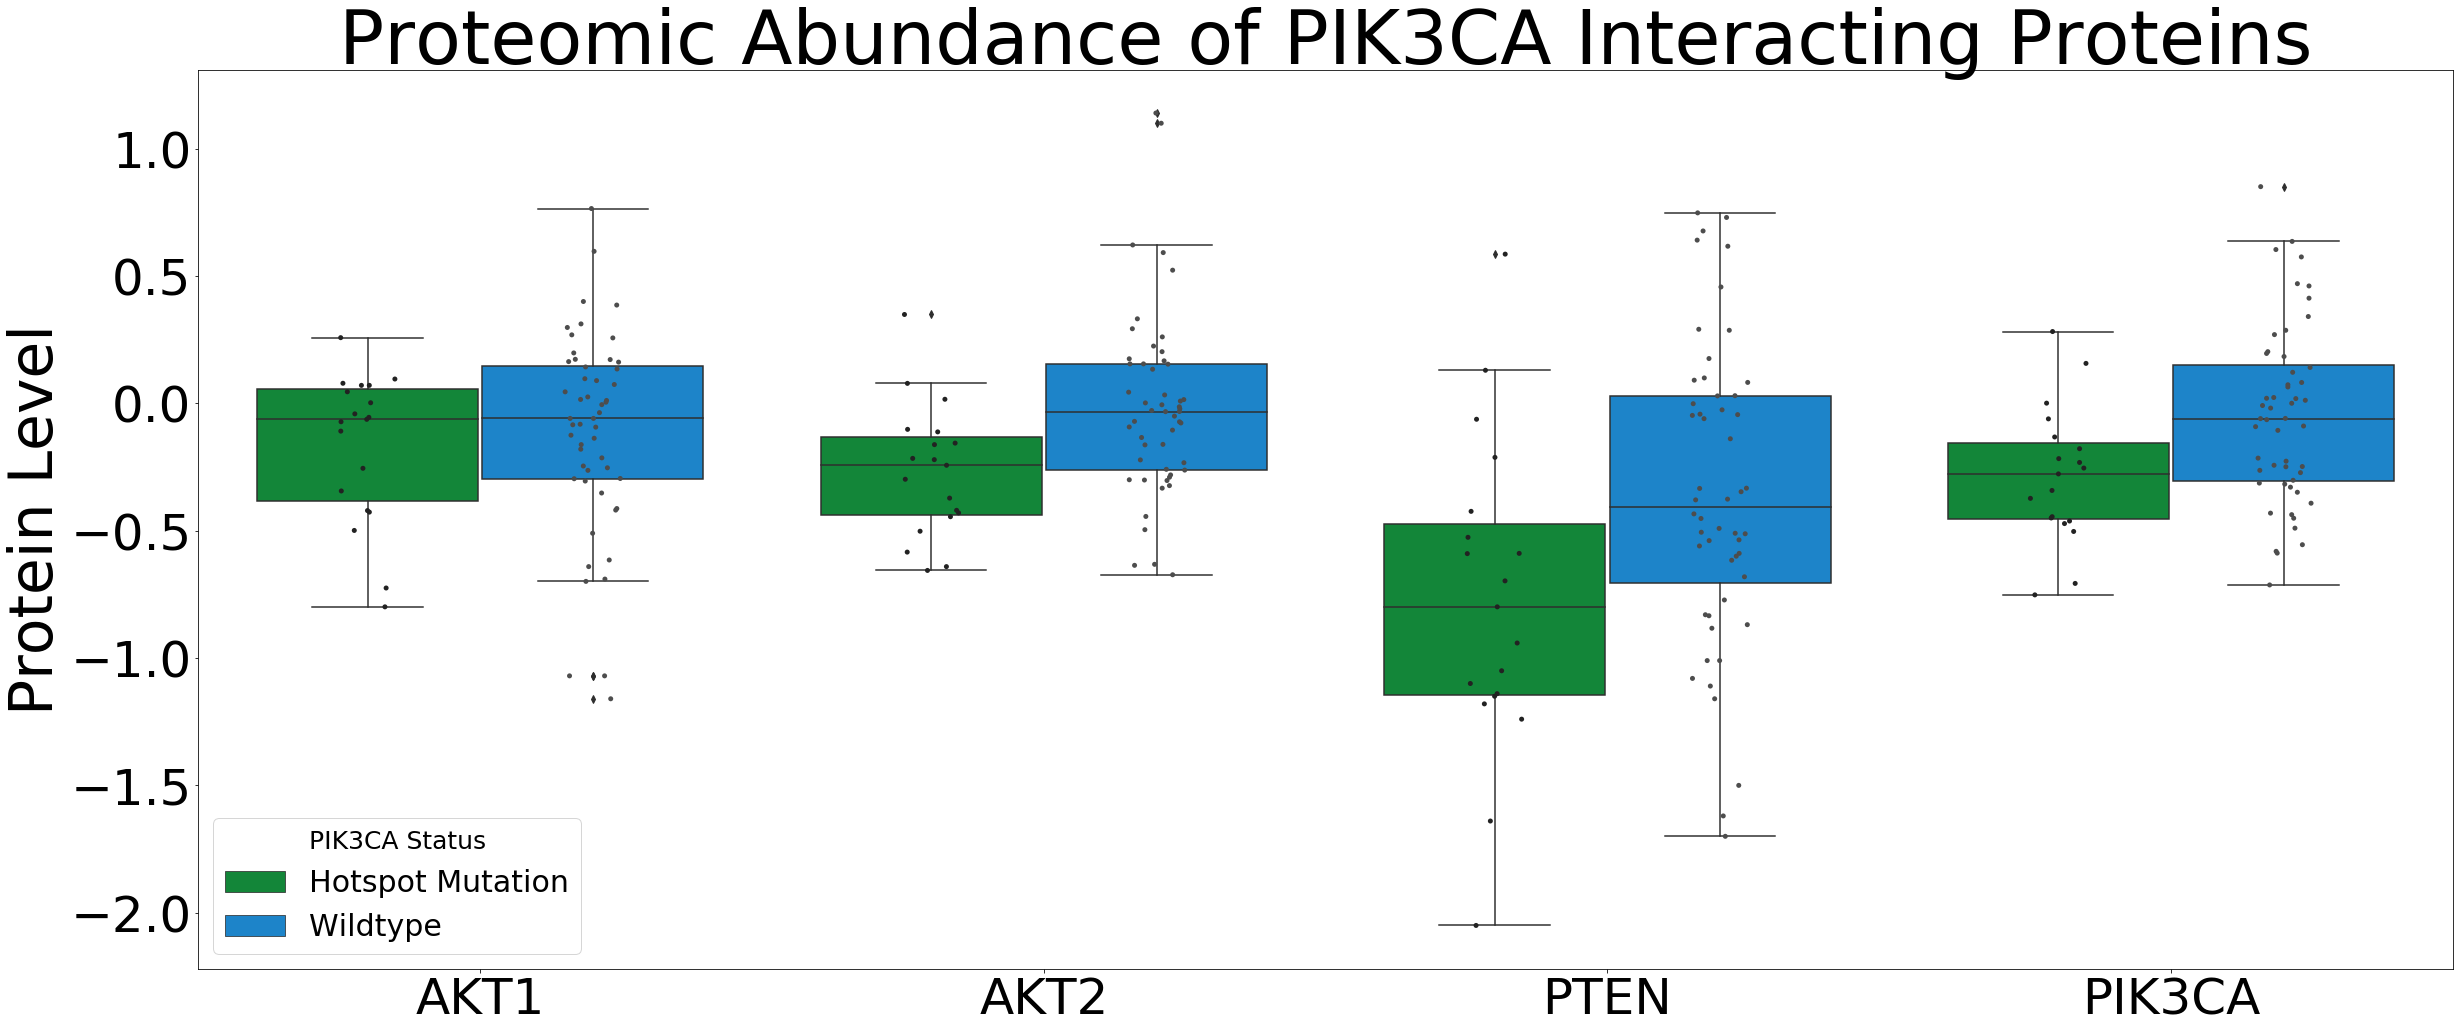

In [3]:
'''Use PIK3CA as gene, AKT1, AKT2, PTEN, and PIK3CA as proteins'''
gene = 'PIK3CA'
protList = ['AKT1','AKT2','PTEN','PIK3CA']

'''A list of mutations present in the hotspot according to our Hotspot3D output'''
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

'''Get the PIK3CA mutation dataframe'''
plotdf = CPTAC.compare_mutations(proteomics, gene)

'''Look only at Tumor patients'''
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]

'''Add in the protein levels for every protein in the list'''
for protein in protList:
    proteindf = CPTAC.compare_mutations(proteomics, protein, gene)
    proteindf = proteindf.loc[proteindf['Patient_Type'] == 'Tumor']
    proteindf = proteindf[[protein]]
    plotdf = plotdf.join(proteindf)

'''Reformat the dataframe to classify Hotspot Mutations, and all other types'''
for ind, row in plotdf.iterrows():
    if ind in hotspot_patients.values:
        plotdf.at[ind, 'Mutation'] = 'Hotspot Mutation'
    else:
        if row['Mutation'] != 'Wildtype':
            plotdf.at[ind, 'Mutation'] = 'Non-Hotspot Mutation'
    
'''Only select the data for hotspot mutations and wildtype'''
plotdf = plotdf.loc[plotdf['Mutation'] != 'Non-Hotspot Mutation']


'''Reformat dataframe for plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Protein', value_name='Signal')
plotdf = plotdf.dropna(axis=0)

'''Create the plot'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Hotspot Mutation": "#009933", "Wildtype": "#008ae6"}
boxplt = sns.boxplot(x='Protein', y='Signal', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Signal', hue='Mutation', dodge=True, jitter=True, color='.3')
boxplt.set_xlabel('')
boxplt.set_ylabel('Protein Level', fontsize='60')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Proteomic Abundance of PIK3CA Interacting Proteins', fontsize = '75')

'''Adjust the legend'''
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Hotspot Mutation', 'Wildtype'], title='PIK3CA Status', fontsize='30', frameon=True)
boxplt.get_legend().get_title().set_fontsize('25')

'''Show Plot'''
fig = boxplt.get_figure()
plt.show()

## Make Proteomics Volcano Plot
#### Hotspot mutation vs wildtype in cancer patients, all interacting proteins

P-Value Cutoff:  0.0033333333333333335
[-0.14159898785425107, -0.4886855060728746, -0.3112027317813765, -0.25557517206477726, -0.08466315789473687, -0.41510088056680183, -0.05739895748987847, -0.22845968623481763, -0.18115434782608694, -0.11387143927125509, 0.20559265182186234, -0.23868729149797568, -0.1283593927125506, -0.19052206477732792, 0.15554527327935228]
[0.4246862510991091, 1.5716397365149368, 1.4557342473620272, 2.195952532325062, 0.21943447284947476, 1.9291467725981157, 0.24815349055981276, 0.5218494187693588, nan, 0.5937453903085383, 0.8964132768018531, 2.0658095350967054, 1.5356497595370284, 0.6954995788306477, 1.4837745405146399]


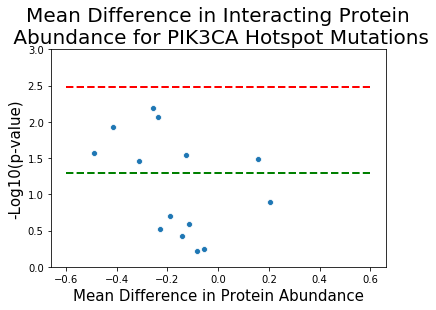

In [4]:
'''Use PIK3CA as the gene, list of interacting proteins as our proteins'''
gene = 'PIK3CA'
protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'MRAS', 'HRAS', 'RPS6KB1', 'PIK3R1', 'PIK3CA','MTOR', 'ERBB3', 'CDK5']

'''Use our bonferroni corrected p-value cutoff, by dividing .05 by the number of interacting proteins'''
p_value_cutoff = .05/len(protList)
print("P-Value Cutoff: ", p_value_cutoff)

'''A list of mutations present in the hotspot according to our Hotspot3D output'''
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

'''Get the PIK3CA mutation dataframe'''
plotdf = CPTAC.compare_mutations(proteomics, gene)

'''Look only at Tumor patients'''
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]

'''Add in the protein levels for every protein in the list'''
for protein in protList:
    proteindf = CPTAC.compare_mutations(proteomics, protein, gene)
    proteindf = proteindf.loc[proteindf['Patient_Type'] == 'Tumor']
    proteindf = proteindf[[protein]]
    plotdf = plotdf.join(proteindf)

'''Reformat the dataframe to classify Hotspot Mutations, and all other types'''
for ind, row in plotdf.iterrows():
    if ind in hotspot_patients.values:
        plotdf.at[ind, 'Mutation'] = 'Hotspot Mutation'
    else:
        if row['Mutation'] != 'Wildtype':
            plotdf.at[ind, 'Mutation'] = 'Non-Hotspot Mutation'

'''Select only the hotspot mutations and wildtype'''
plotdf = plotdf.loc[plotdf['Mutation'] != 'Non-Hotspot Mutation']

'''Do a t-test, comparing the protein levels in hotspot mutation vs wildtype groups, for every protein in our protein list'''
diff_means = []
p_values = []
for prot in plotdf:
    if prot != "Mutation":
        '''Do t-test, record p-value'''
        hotspotdf = plotdf.loc[plotdf['Mutation'] == 'Hotspot Mutation']
        otherdf = plotdf.loc[plotdf['Mutation'] != 'Hotspot Mutation']
        ttest = scipy.stats.ttest_ind(hotspotdf[prot], otherdf[prot])
        p_values.append(ttest[1])
        
        '''Compare the differences in the means of the 2 groups, record the mean difference'''
        hotspot_mean = np.mean(hotspotdf[prot])
        other_mean = np.mean(otherdf[prot])
        mean_diff = hotspot_mean - other_mean
        diff_means.append(mean_diff)
        

'''record the negative log of our p-values, for our volcano plot'''
neg_log_pvals = []
for item in p_values:
    neg_log_pvals.append(-1 * np.log10(item))
    
'''Print the difference in means of the two groups, and negative log of our p-values'''
print(diff_means)
print(neg_log_pvals)

'''Format the data in a dataframe to create our plot'''
df = pd.DataFrame({'-Log10(p-value)': neg_log_pvals, 'Mean Difference in Protein Abundance':diff_means, 'Protein':protList})

'''Make a line to illustrate the bonferroni correction cutoff p-value on the plot'''
bonferroniCutoff= p_value_cutoff
cutoffLine = (-1* np.log10(bonferroniCutoff))
unadjusted_pval_line = (-1*np.log10(.05))

'''Display the plot'''
a4_dims = (12, 7.5)
#fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.scatterplot(x = "Mean Difference in Protein Abundance", y = "-Log10(p-value)", data =df)
ax.set_title("Mean Difference in Interacting Protein\n Abundance for PIK3CA Hotspot Mutations", fontsize = '20')
ax.set_xlabel('Mean Difference in Protein Abundance', fontsize = '15')
ax.set_ylabel('-Log10(p-value)', fontsize='15')
ax.set(ylim=(0, 3))
ax.plot([-.6,.6],[cutoffLine,cutoffLine], linewidth=2, linestyle='--', color="red")
ax.plot([-.6,.6],[unadjusted_pval_line, unadjusted_pval_line], linewidth=2, linestyle='--', color="green")
plt.show()